# Hamiltonian Paths and Cycles
### Edward Duran
Creates a class that generates a Hamiltonian path or cycles for a given graph should one exist.

These algorithms come from Probability and Computing by Michael Mitzenmacher and Eli Upfal:

<img src="Algorithms.png" alt="algorithms" width="300"/>

In [1]:
import numpy as np
import numpy.random as rand
from pathlib import Path
import copy


class HamPath:
    """
    Takes a graph and uses the algorithms given in Mitzenmacher, Upfal\'s Probability and Computing for finding a Hamiltonian cycle or path.
    Gives various means of showing the progress of the algorithm.\n
    You can call the following upon initialization:\n
    G - calls the graph given at initialization\n
    edges_dict() - gives a dictionary mapping a vertex to a list of vertices connected to it.\n
    ham_path_dict - gives a dictionary of 2 entries corresponding algorithm 1 and 2 resp.\n
        -If  ham_path has been run for either algorithm, it will contain the results of the previous run.
        If it has not been run, it will contain empty tuples
    cycles() - Returns a list of boolean values stating whether the values for each algorithm were found using cycles=True
    algo_one() - performs exactly one full run of the first algorithm. It may not give a Hamiltonian cycle.\n
    algo_two() - performs exactly one full run of the second algorithm. It may not give a Hamiltonian cycle.\n
        - keep_log will maintain a string containing all the steps the algorithm went through to get the final path if set to true.
        If False, it will only log the final string.
    algo_two_init_dict() - generates the initial dict used in algorithm 2\n
    path_to_edges(path: list) - converts a path into a tuple that may be a set of edges in a graph.\n
    is_cycle(path:list) - checks if a given path is a cycle in G\n
    ham_path(algorithm=1, cycle=False) - Runs the designated algorithm until either a path or cycle is given depending on cycle.\n
    ham_path_plot(algorithm=1, cycle=False, new=True) - Generates a path and plots that path from either a path that already exists or from a new path.
        -If new is set to False, the function may still re-run the algorithm if ham_path has not already run with the proper settings.
    frames(algorithm=1, cycle=False, new=True) - Generates a graph for each step of the given algorithm. It can either use an already existing instance or create a new one.
    animation(algorithm=1, cycle=False, new=True) - Creates an animation using the frames method above
    log_info(algorithm, cycle, new=True) - Saves a log along with graphs of each step performed by the algorithm given.
    """
    def __init__(self,G):
        self.G = G
        self._edges_dict = G.to_dictionary()    
        self._has_run_ham_path = [False, False]
        self._ham_path_dict = {1:([],'',[]), 2:([],'',[])}
        self._cycles = [False, False]
        self.G.graphplot(save_pos=True)



    def edges_dict(self):
        """
        Returns a copy of the dictionary of the edges that make up the graph.
        """
        return copy.deepcopy(self._edges_dict)
    
    
    def cycles(self):
        """
        Returns a list of boolean values stating whether the values for each algorithm were found using cycles=True
        """
        return self._cycles
    
    
    def algo_two_init_dict(self):
        """
        Creates the initial dictionary to use in the second algorithm
        """
        d=self.edges_dict()
        (rand.shuffle(edges) for edges in d.values())
        return {i:[edge_list, []] for i, edge_list in d.items()}
        
        
    def _rotate(self,path:list, i1:int) -> list:
        """
        Takes two indices of a path and performs a rotation on the path.
        """
        n = len(path)
        if i1 >= n-1:
            return path
        else:
            l = path[:i1+1]
            r = path[i1+1:]
            l.extend(r[::-1])
            return l
    
    
    def _path_str(self, path):
        return '-'.join([str(x) for x in path])
        
        
    def _log_step(self, path: list, u: int, step, d: dict, i:int):
        iter_str = "Iteration:\t{}".format(i)
        path_str = "Path:\t{}".format(self._path_str(path))
        u_str = 'u:\t{}'.format(u)
        v_t = 'v_t:\t{}'.format(path[-1])
        step_str = 'Step:\t{}'.format(step)
        log_list = [iter_str,path_str,v_t, u_str,step_str]
        d_str = ['{}:\t{}'.format(vertex, edge) for vertex, edge in d.items()]
        log_list.extend(d_str)
        return log_list
    
    
    def _log_join(self, log_list):
        return '\n'.join(log_list)
    
    
    def algo_one(self, keep_log=True):
        """
        Follows the first more efficient algorithm given in Mitzenmacher and Upfal. 
        Returns a tuple consisting of\n
            -the final path that could be a Hamiltonian path/cycle,\n
            -a log of steps that were taken,\n 
                - if keep_log=False, the log will only consist of the final path\n
            -a list of paths made in the process.\n
        -It doesn't always return a Hamiltonian path/cycle. 
        """
        head = rand.choice(self.G.vertices())
        path = [head]
        d = self.edges_dict()

        head_vertices = d[head]
        step = 'a'
        i=0
        log_list = []
        path_list = []
        
        #Python views empty lists as false. 
        while head_vertices:
            i+=1
            log_path = path.copy()
            path_list.append(log_path)
            u = head_vertices[0]
            
            d[head].pop(0)
            d[u].remove(head)
            
            if u in path:
                step = 'd'
                path = self._rotate(path, path.index(u))
            else:
                step = 'c'
                path.append(u)
            if keep_log:
                (log_list
                 .append(self._log_join(
                     self._log_step(log_path, u,step, d,i))
                        ))
            
            head = path[-1]
            head_vertices = d[head]
        
        log_list.append("Final path:\t{}".format(self._path_str(path)))
        path_list.append(path)
        return path, '\n----------------\n'.join(log_list), path_list

    
    def path_to_edges(self, path: list):
        """
        Generates a list of tuples used as edges traversed via the path given. 
        """
        def edge_maker(k):
            vertices = sorted((path[k], path[k+1]))
            return tuple((vertices[0],vertices[1],None))

        return [ edge_maker(k) for k in range(len(path)-1) ]
    

    
    
    def _is_cycle(self, path:list) -> bool:
        """
        Determines if path given can be considered a cycle. 
        """
        return path[0] in self._edges_dict[path[-1]]
    
    
    def _prob_str(self, prob_list):
        return ('Probabilities:\t{}'.format( np.round(prob_list, 2).tolist() ))
    
    
    
    def algo_two(self, keep_log=True):  
        """
        Follows the second algorithm given in Mitzenmacher and Upfal.
        While not efficient, the mathematics is easier.
        Returns a tuple consisting of\n
            -the final path that could be a Hamiltonian path/cycle,\n
            -a log of steps that were taken,\n 
                - if keep_log=False, the log will only consist of the final path\n
            -a list of paths made in the process.\n
        -It doesn't always return a Hamiltonian path/cycle. 
        """
        vertices = self.G.vertices()
        n = self.G.num_verts()
        d = self.algo_two_init_dict()
        
        def update_dict(head, u):
                d[head][0].remove(u)
                d[head][1].append(u)

        head = rand.choice(vertices)
        path = [head]
        unused_edges = d[head][0]
        
        u = -1
        i=0
        
        log_list = []
        path_list = []

        while unused_edges:
            i+=1
            log_path = path.copy()
            path_list.append(log_path)
            used_edges = d[head][1]
            num_used = len(used_edges)
            prob_list=[1/n, num_used/n, 1-1/n-num_used/n]
            
            
            step = rand.choice([1,2,3],
                                p=prob_list
                               )
            if step == 1:
                step = 'i'
                path = path[::-1]

            elif step == 2:
                step = 'ii'
                u = rand.choice(used_edges)
                path = self._rotate(path, path.index(u))


            else:
                u = unused_edges[0]
                if u in path:
                    step = 'iii.2'
                    path = self._rotate(path, path.index(u))
                else:
                    step = 'iii.1'
                    path.append(u)

            if u in unused_edges:
                update_dict(head, u)
                
            if keep_log:
                log_step = self._log_step(log_path, u, step, d,i)
                log_step.insert(1, self._prob_str(prob_list))
                log_list.append( self._log_join(log_step) )

            head = path[-1]
            unused_edges = d[head][0]
        
        log_list.append("Final path:\t{}".format(self._path_str(path)))
        path_list.append(path)
        return path, '\n----------------\n'.join(log_list), path_list
    
    
    def algo_one_path(self):
        """
        Returns the path from the last time algo_one was run. 
        If algo_one has not been run, will return [].
        """
        return self._ham_path_dict[1][0]   

    
    def algo_one_log(self):
        """
        Returns the log of steps from the last time algo_one was run. 
        If algo_one has not been run, will return ''.
        """
        return self._ham_path_dict[1][1]
    
    
    def algo_one_paths(self):
        """
        Returns the list of paths made in each iteration of the algorithm from the last time algo_one was run. 
        If algo_one has not been run, will return [].
        """
        return self._ham_path_dict[1][2]
    
    
    def algo_two_path(self):
        """
        Returns the path from the last time algo_two was run. 
        If algo_two has not been run, will return [].
        """
        return self._ham_path_dict[2][0]   

    
    def algo_two_log(self):
        """
        Returns the log of steps from the last time algo_two was run. 
        If algo_two has not been run, will return ''.
        """
        return self._ham_path_dict[2][1]
    
    
    def algo_two_paths(self):
        """
        Returns the list of paths made in each iteration of the algorithm from the last time algo_two was run. 
        If algo_two has not been run, will return [].
        """
        return self._ham_path_dict[2][2]
    
    
    def clear_log(self, algorithm):
        if algorithm==1:
            self._ham_path_dict[1][1]
        elif algorithm==2:
            self._ham_path_dict[2][1]
        else: 
            raise ValueError("algorithm should only include 1 or 2")
    
    
    def _algo(self,algorithm=1):
        """
        Returns a lambda function that allows you to run either the first algorithm or second.
        Inputing anything other than 1 or 2 into algorithm will return an error.
        """
        if algorithm==1:
                algo = lambda x: self.algo_one(keep_log=x)
        elif algorithm==2:
                algo = lambda x: self.algo_two(keep_log=x)
        else:
            raise ValueError("algorithm should only include 1 or 2")
        return algo
    
    
    def ham_path(self, algorithm=1, cycle=False, keep_log=True):
        """
        Might eventually give a Hamiltonian path using either algo_one or algo_two.
        If instead of just a Hamiltonian path, one wants a cycle, use cycle=True.
        """
        num_vers = self.G.num_verts()
        path = []
        
        algo = self._algo(algorithm)
        tries = 0
        
        is_cycle = False
        while len(path)!=num_vers or not is_cycle:
            tries+=1
            path, log,paths = algo(keep_log)
            is_cycle =  cycle and self._is_cycle(path)
        
        print("The algorithm took {} tries".format(tries))
            
        if cycle:
            path.append(path[0])
            paths.append(path)
            
        self._ham_path_dict[algorithm] = (path, log, paths)
        self._has_run_ham_path[algorithm-1]=True
        self._cycles[algorithm-1]=cycle
        return path
    
    
    def _need_new(self, algorithm, cycle, new):
        if new:
            return True
        if not self._has_run_ham_path[algorithm-1]:
            return True
        if cycle and not self._cycles[algorithm-1]:
            return True
        return False
    
    
    def _need_new_ham_path(self, algorithm, cycle, new, keep_log):
        if self._need_new(algorithm, cycle, new):
            self.ham_path(algorithm=algorithm, cycle=cycle, 
                          keep_log=keep_log)
        #else:
        #    path, log, paths = self._ham_path_dict[algorithm]
        return self._ham_path_dict[algorithm]
    
    
    def ham_path_plot(self, algorithm=1, cycle=False, new=True, keep_log=True, path_as_title=True):
        """
        Returns a plot of a Hamiltonian path/cycle and its corresponding log.\n
        algorithm corresponds with which algorithm you would like to use: 1 or 2.\n
        cycle corresponds with whether you would the path to be a cycle (True) or a path (False).\n
        new corresponds with if a new path/cycle should be generated. \n
        keep_log corresponds with whether the algorithm should maintain a log if it runs 
        """
        path,_, _ = self._need_new_ham_path(algorithm, cycle, new, keep_log)
        if path_as_title:
            title = self._path_str(path)
        else:
            title = ''
        edges = self.path_to_edges(path)
        p = self.G.plot(edge_colors={'crimson':edges}, 
                        vertex_colors={'azure': [path[0]]},
                        title=title)
        return p
    
   

    def ham_path_only_plot(self, algorithm=1, cycle=False, 
                           new=True, keep_log=True, path_as_title=False):
        """
        Returns a plot of the graph of vertices which is just connected by the Hamiltonian cycle.
        """
        
        G_copy = self.G.copy()
        path,_, _ = self._need_new_ham_path(algorithm, cycle, new, keep_log)
        
        edges = self.path_to_edges(path)
        deleted_edges = set(self.G.edges())-set(edges)
        deleted_edges = list(deleted_edges)
        G_copy.delete_edges(deleted_edges)
        
        if path_as_title:
            title = self._path_str(path)
        else:
            title = ''
        p = G_copy.plot(edge_color='crimson', 
                        vertex_colors={'azure': [path[0]]},
                        title=title)
        #self.G = Graph(self._edges_dict)
        
        return  p
    
    def _make_frames_from_path_list(self, path_list):
        edges = [self.path_to_edges(path) for path in path_list]
        pl_list = []
        for k in range(len(path_list)):
            path = path_list[k]
            pl_list.extend([self.G.plot(edge_colors = {'lightcoral':edges[k]}, 
                                        vertex_colors={'azure': path},
                                        title=self._path_str(path))])
        return graphics_array(pl_list)

    def frames(self, algorithm=1, cycle=False, new=True, keep_log=True):
        """
        Returns a tuple including:\n
        -a list of frames of graphs in a successful use of either algorithm one or two\n
        -a log of steps taken during algorithm\n
        algorithm corresponds with which algorithm you would like to use: 1 or 2.\n
        cycle corresponds with whether you would the path to be a cycle (True) or a path (False).\n
        new corresponds with if you would like to generate a new path/cycle.
        """
        _,_,paths = self._need_new_ham_path(algorithm, cycle, new, keep_log)

        return self._make_frames_from_path_list(paths)
    
    
    def animation(self, algorithm=1, cycle=False, new=True, keep_log=True):
        """
        Returns a tuple including\n
            -an animation of frames\n
            -a log of steps taken in the successful algorithm\n
        algorithm corresponds with which algorithm you would like to use: 1 or 2.\n
        cycle corresponds with whether you would the path to be a cycle (True) or a path (False).\n
        new corresponds with if you would like to generate a new path/cycle. 
        """
        frames = self.frames(algorithm, cycle, new, keep_log)
        return animate(frames,figsize=[10,10])
    
    
    def log_info(self, algorithm, cycle, new=True):
        frames = self.frames(algorithm, cycle, new)
        log = self._ham_path_dict[algorithm][1]
        Path("./graph_logs_algo{}".format(algorithm)).mkdir(parents=True, exist_ok=True)
        text_file = open("graph_logs_algo{}/graph_algo{}.txt".format(algorithm,algorithm), "w+")
        n = text_file.write(log)
        text_file.close()

        for i in range(len(frames)):
            frames[i].save_image('graph_logs_algo{}/graph{}_algo{}.png'.format(algorithm, i+1, algorithm))  
            

    def failure_frames(self, algorithm):
        """
        Runs the specified algorithm until it fails and returns a list of graphics and a log of steps.
        """
        algo = self._algo(algorithm)
        path, log, paths = algo(True)
        while len(path)==self.G.num_verts():
            path, log,paths = algo(True)

        return self._make_frames_from_path_list(paths), log
    
    
    def failure_log(self, algorithm):
        """
        Runs the specified algorithm until it fails and then logs the steps taken in the specified algorithm.
        """
        frames, log = self.failure_frames(algorithm)
        
        Path("./graph_fail_logs_algo{}".format(algorithm)).mkdir(parents=True, exist_ok=True)
        text_file = open("graph_fail_logs_algo{}/graph_algo{}.txt".format(algorithm,algorithm), "w+")
        n = text_file.write(log)
        text_file.close()
        
        for i in range(len(frames)):
            frames[i].save_image('graph_fail_logs_algo{}/graph{}_algo{}.png'.format(algorithm, 
                                                                               i+1, algorithm))  

        

In [2]:
from numpy.random import default_rng
class RandomHamiltonian(HamPath):
    """
    Creates a random graph given a certain number n of vertices.\n
    Upon initialization, one can call the following\n
    n - the number of vertices\n
    q - the probability of a vertex adding another vertex to the edge\n
    edges_dict - a dictionary whose keys are vertices and values are a list of vertices that form an edge with the vertex\n
    log_edges() - creates a text file that shows edges_dict.
    """
    
    def __init__(self,n, directed = False):
        self.__rng = default_rng()
        self._n = n
        self.q = 20*np.log(n)/n
        if self.q > 1:
            # This is really just measuring if n is bigger than 90...
            raise ValueError('Value set for n is too small.')

        
        def vector_array(i):
            vals = self.__rng.choice(2, size=self._n, p=[1-self.q,self.q])
            result = np.arange(self._n) * vals
            result = np.delete(result, i)
            result = result[ result !=0 ]
            
            if vals[0] and i!=0:   
                return np.insert(result, 0,0)
            else:
                return result
            
                
        d={i:vector_array(i) for i in  range(n)}
        if not directed:
            for vector, edges in d.items():
                for edge in edges:
                    d[edge] = np.append(d[edge], vector)
            d={vector:np.unique(edges).tolist() 
                             for vector, edges in d.items()}
        else:
            d={i:d[i].tolist() for i in range(n)}
        
        HamPath.__init__(self, Graph(d))
        
    
    def num_vertices(self):
        return self._n
        
        
        
    def set_vertex_positions(self, positions: dict):
        """
        Sets the layout of the vertices on the graph. The possibilities are
        'circular', 'ranked'(probably won't work), 'planar'(probably won't work),
        'spring', 'tree' (probably won't work)
        """
        self.G.graphplot(save_pos=True, pos=positions)
        
    def circular_vertices(self):
        """
        Puts vertices in a circular layout.
        The full graph may look bad.
        """
        self.G.graphplot(save_pos=True, layout='circular')
        
    
    def log_edges(self):
        """
        Creates a text file that shows info from a previously run .
        """
        dict_str = ["{}:{}\n".format(vector, edges) 
                    for vector, edges in self._edges_dict.items()]
        text_file = open("random_hamitonian_graph.txt", "w+")
        n = text_file.write('\n'.join(dict_str))
        text_file.close()

In [3]:
class HamPathforGnp(HamPath):
    """
    Generates a random GNP graph and produces a type HamPath object from it. 
    """
    def __init__(self, n):
        self.p = 40*np.log(n)/n
        if self.p>1:
            raise ValueError('Value set for n is too small.')
        
        HamPath.__init__(self, graphs.random.RandomGNP(n,self.p))
        
    
    def circular_vertices(self):
        """
        Puts vertices in a circular layout.
        The full graph may look bad.
        """
        self.G.graphplot(save_pos=True, layout='circular')

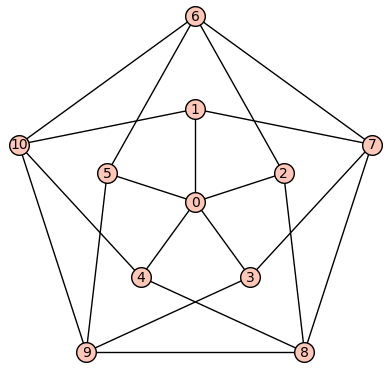

The algorithm took 4 tries


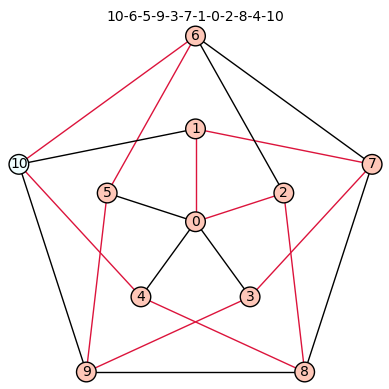

0.018454313278198242


In [4]:
import time

G = graphs.GrotzschGraph()
G.show()
g = HamPath(G)
t1 = time.time()
p = g.ham_path_plot(algorithm=2, cycle=True, new=False)
t2=time.time()
p.show()
print(t2-t1)

In [26]:
print( g.algo_two_log() )

Iteration:	1
Probabilities:	[0.09, 0.0, 0.91]
Path:	6
v_t:	6
u:	2
Step:	iii.1
0:	[[1, 2, 3, 4, 5], []]
1:	[[0, 7, 10], []]
2:	[[0, 6, 8], []]
3:	[[0, 7, 9], []]
4:	[[0, 8, 10], []]
5:	[[0, 6, 9], []]
6:	[[5, 7, 10], [2]]
7:	[[1, 3, 6, 8], []]
8:	[[2, 4, 7, 9], []]
9:	[[3, 5, 8, 10], []]
10:	[[1, 4, 6, 9], []]
----------------
Iteration:	2
Probabilities:	[0.09, 0.0, 0.91]
Path:	6-2
v_t:	2
u:	0
Step:	iii.1
0:	[[1, 2, 3, 4, 5], []]
1:	[[0, 7, 10], []]
2:	[[6, 8], [0]]
3:	[[0, 7, 9], []]
4:	[[0, 8, 10], []]
5:	[[0, 6, 9], []]
6:	[[5, 7, 10], [2]]
7:	[[1, 3, 6, 8], []]
8:	[[2, 4, 7, 9], []]
9:	[[3, 5, 8, 10], []]
10:	[[1, 4, 6, 9], []]
----------------
Iteration:	3
Probabilities:	[0.09, 0.0, 0.91]
Path:	6-2-0
v_t:	0
u:	1
Step:	iii.1
0:	[[2, 3, 4, 5], [1]]
1:	[[0, 7, 10], []]
2:	[[6, 8], [0]]
3:	[[0, 7, 9], []]
4:	[[0, 8, 10], []]
5:	[[0, 6, 9], []]
6:	[[5, 7, 10], [2]]
7:	[[1, 3, 6, 8], []]
8:	[[2, 4, 7, 9], []]
9:	[[3, 5, 8, 10], []]
10:	[[1, 4, 6, 9], []]
----------------
Iteration:	4
Pro

In [7]:
def path_to_edges(path: list):
    """
    Generates a list of tuples used as edges traversed via the path given. 
    """
    def edge_maker(k):
        vertices = sorted((path[k], path[k+1]))
        return tuple((vertices[0],vertices[1],None))

    return iter(edge_maker(k) for k in range(len(path)-1))

In [8]:
path_to_edges(path)

<generator object path_to_edges.<locals>.<genexpr> at 0x6ffed444d7d0>

In [10]:
g.edges_dict()

{0: [1, 2, 3, 4, 5],
 1: [0, 7, 10],
 2: [0, 6, 8],
 3: [0, 7, 9],
 4: [0, 8, 10],
 5: [0, 6, 9],
 6: [2, 5, 7, 10],
 7: [1, 3, 6, 8],
 8: [2, 4, 7, 9],
 9: [3, 5, 8, 10],
 10: [1, 4, 6, 9]}

In [42]:
#We can check if it is in fact a Hamiltonian cycle via the following function
#Note that HamPath already checks this while computing

def is_cycle(path: list, num_vertices: int) -> bool:
    """
    Takes a path within a graph and the number of vertices the graph has and returns a bool, where True indicates a cycle and False indicates no cycle.\n
    Assumes that the vertices in the graph are labeled 0 to (num_vertices-1).\n
    If False, is_cycle will print out some info on why it is not a Hamiltonian cycle.
    """
    path_info=[]
    if path[0] == path[-1]:
        path = path[0:-1]
    for i in range(num_vertices):
        if i not in path:
            path_info.append("{} not in path".format(i))
        if path.count(i)>1:
            path_info.append("{} occurs more than once".format(i))
    if len(path_info) == 0:
        return True
    else:
        print('\n'.join(path_info))
        return False
    

In [45]:
path = g.algo_two_path()
is_cycle(path, 11)

True

In [10]:
from pympler import tracker
tr = tracker.SummaryTracker()
g.ham_path(algorithm=1, cycle=True, keep_log=True)
tr.print_diff()

The algorithm took 2 tries
                           types |   # objects |   total size
================================ | =========== | ============
                             str |           0 |      3.01 KB
                            dict |           1 |    248     B
               functools.partial |           2 |    192     B
                         Context |           2 |    160     B
                            code |           1 |    144     B
           function (store_info) |           1 |    144     B
      asyncio.events.TimerHandle |           1 |    128     B
           asyncio.events.Handle |           1 |    112     B
                         weakref |           1 |     88     B
                          method |           1 |     72     B
                _ast.Interactive |           1 |     64     B
                             int |           2 |     56     B
                           float |           1 |     24     B
  pympler.tracker.SummaryTracker |         

In [12]:
from pympler import tracker
tr = tracker.SummaryTracker()
g.ham_path(algorithm=2, cycle=True, keep_log=True)
tr.print_diff()

The algorithm took 8 tries
                           types |   # objects |   total size
================================ | =========== | ============
                             str |           0 |      8.24 KB
                            list |          -1 |    336     B
                            dict |           1 |    248     B
               functools.partial |           2 |    192     B
                         Context |           2 |    160     B
                            code |           1 |    144     B
           function (store_info) |           1 |    144     B
      asyncio.events.TimerHandle |           1 |    128     B
           asyncio.events.Handle |           1 |    112     B
                         weakref |           1 |     88     B
                          method |           1 |     72     B
                _ast.Interactive |           1 |     64     B
                             int |           2 |     56     B
                           float |         

In [12]:
'{:.2f}'.format(1.2222222)

'1.22'